# Behavior Analysis: Individual Mouse Screening

Press SHIFT + ENTER to run code

### USER INPUT!

In [2]:
## Define project
project_name = 'project_Sandra_Form1perc_Proglumide_CohortCombined'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['Combined']
selected_conditions = ['Saline','Proglumide']

### Main Code: Create Heatmap per Mouse, Screening Behavior Instances per Bin (ACROSS EACH GROUPS)

Found CSV files: 37
Combined_Saline_F4_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1perc_F3_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_M1_1PercentFormalin_Saline_ruinedByDeadCompMouseDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1Perc_F4_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1perc_F8_salineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_M5_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_M6_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1perc_F10_salineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_F8_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_F3_1percentFormalin_salineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1perc_F6_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv
Combined_Saline_Form1per

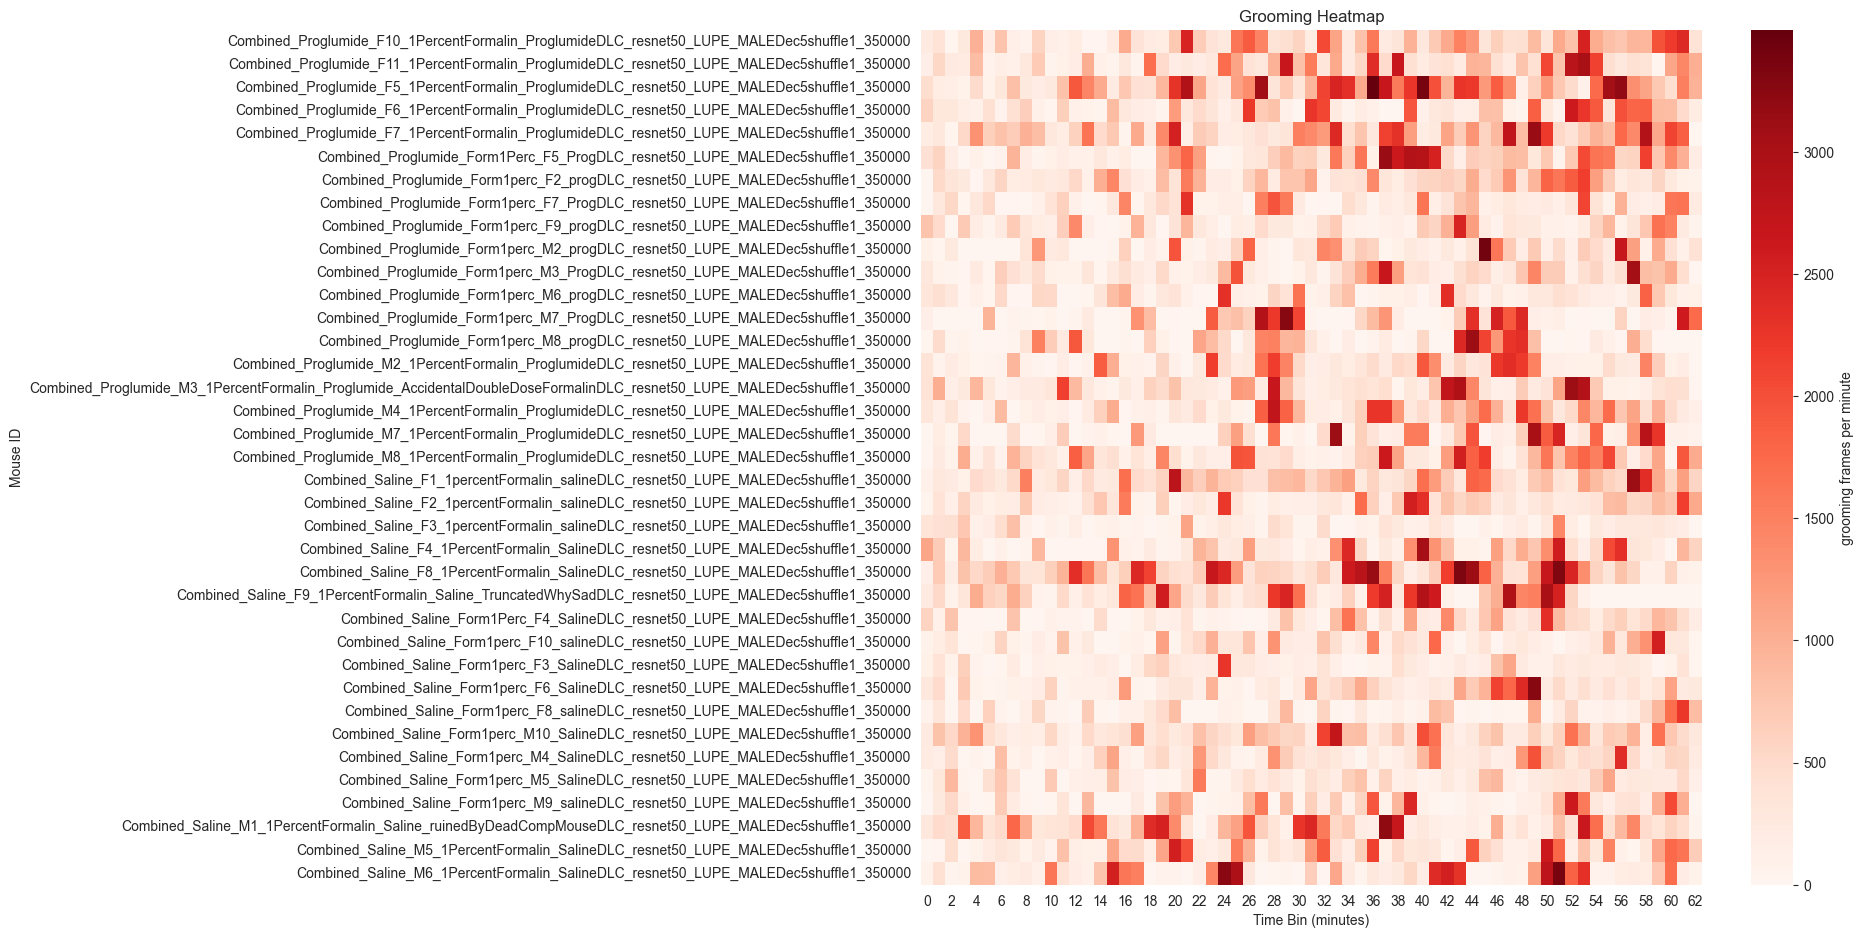

Saved heatmap for 'grooming' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/grooming_heatmap.svg


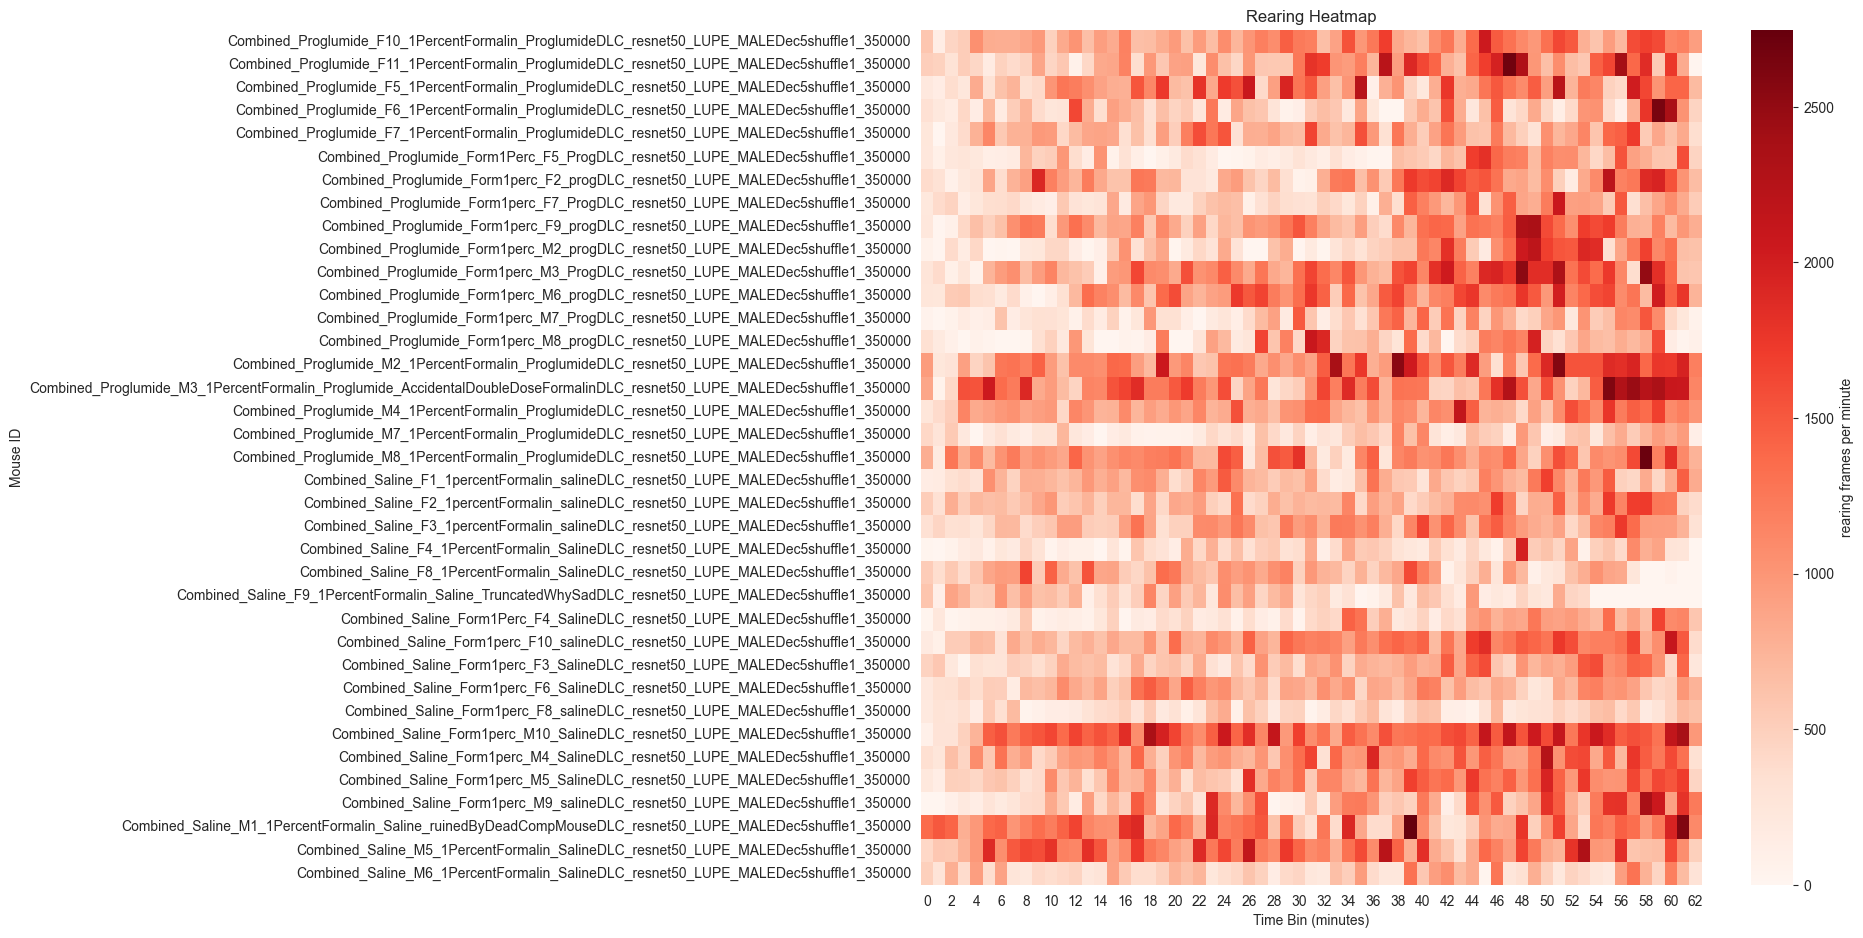

Saved heatmap for 'rearing' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/rearing_heatmap.svg


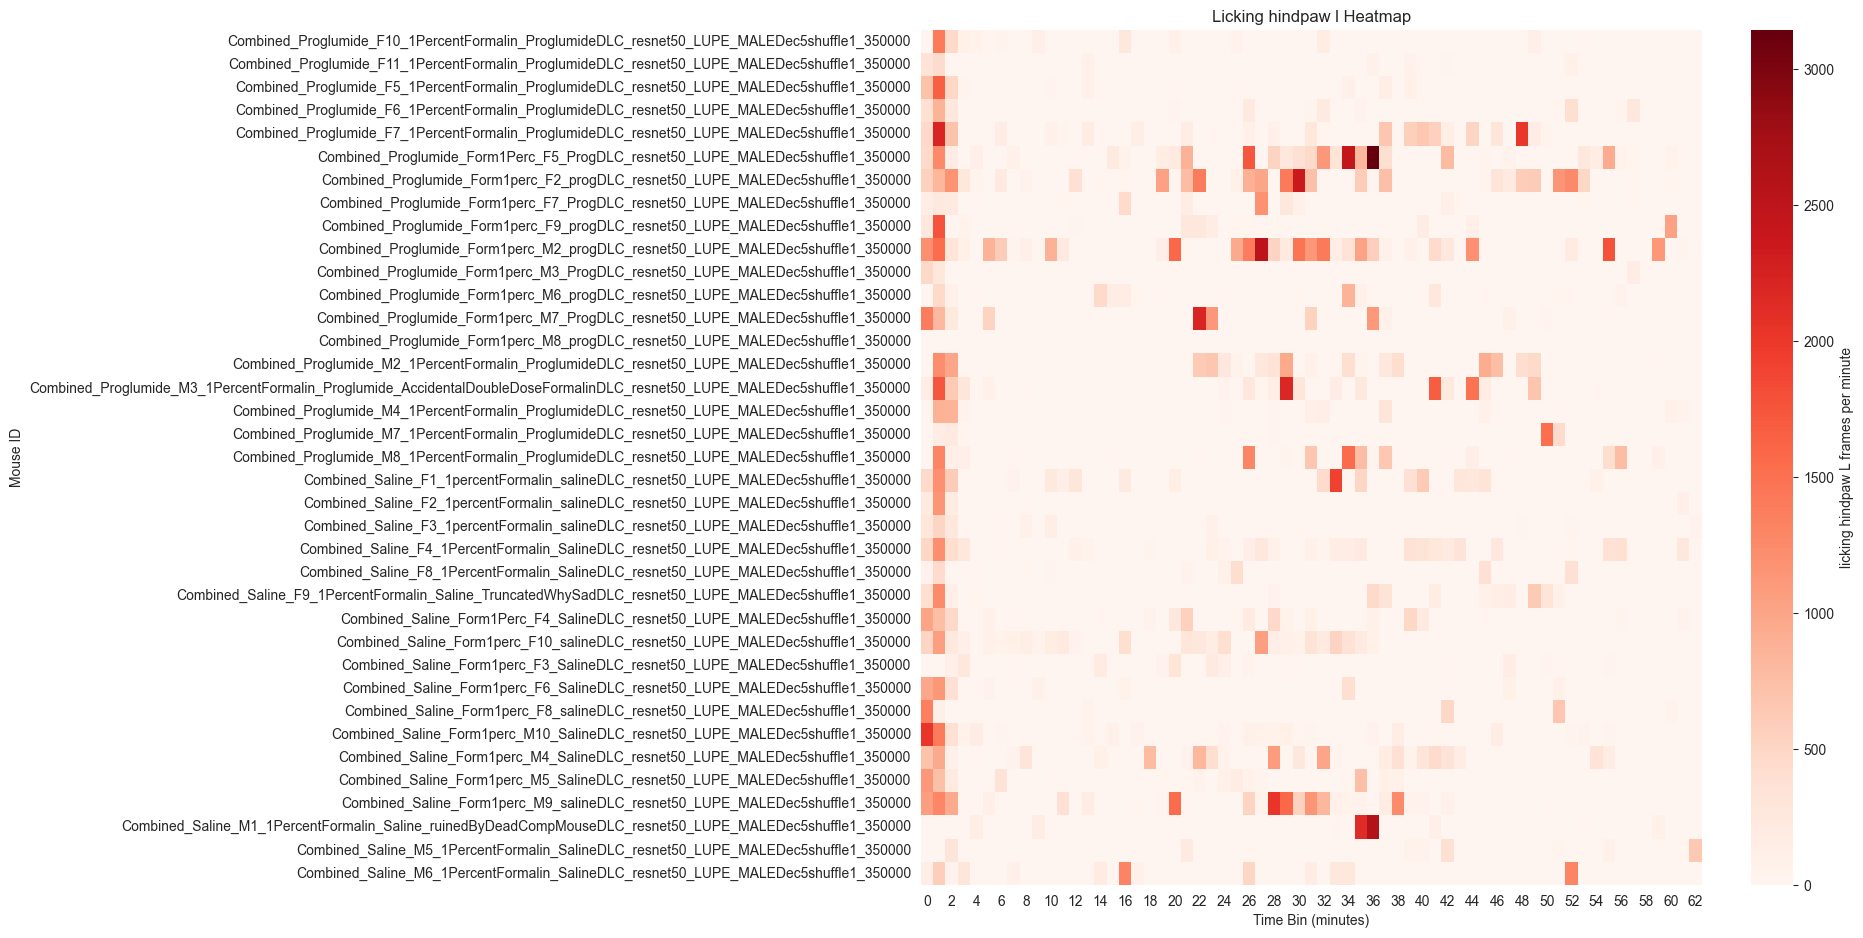

Saved heatmap for 'licking hindpaw L' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/licking_hindpaw_L_heatmap.svg


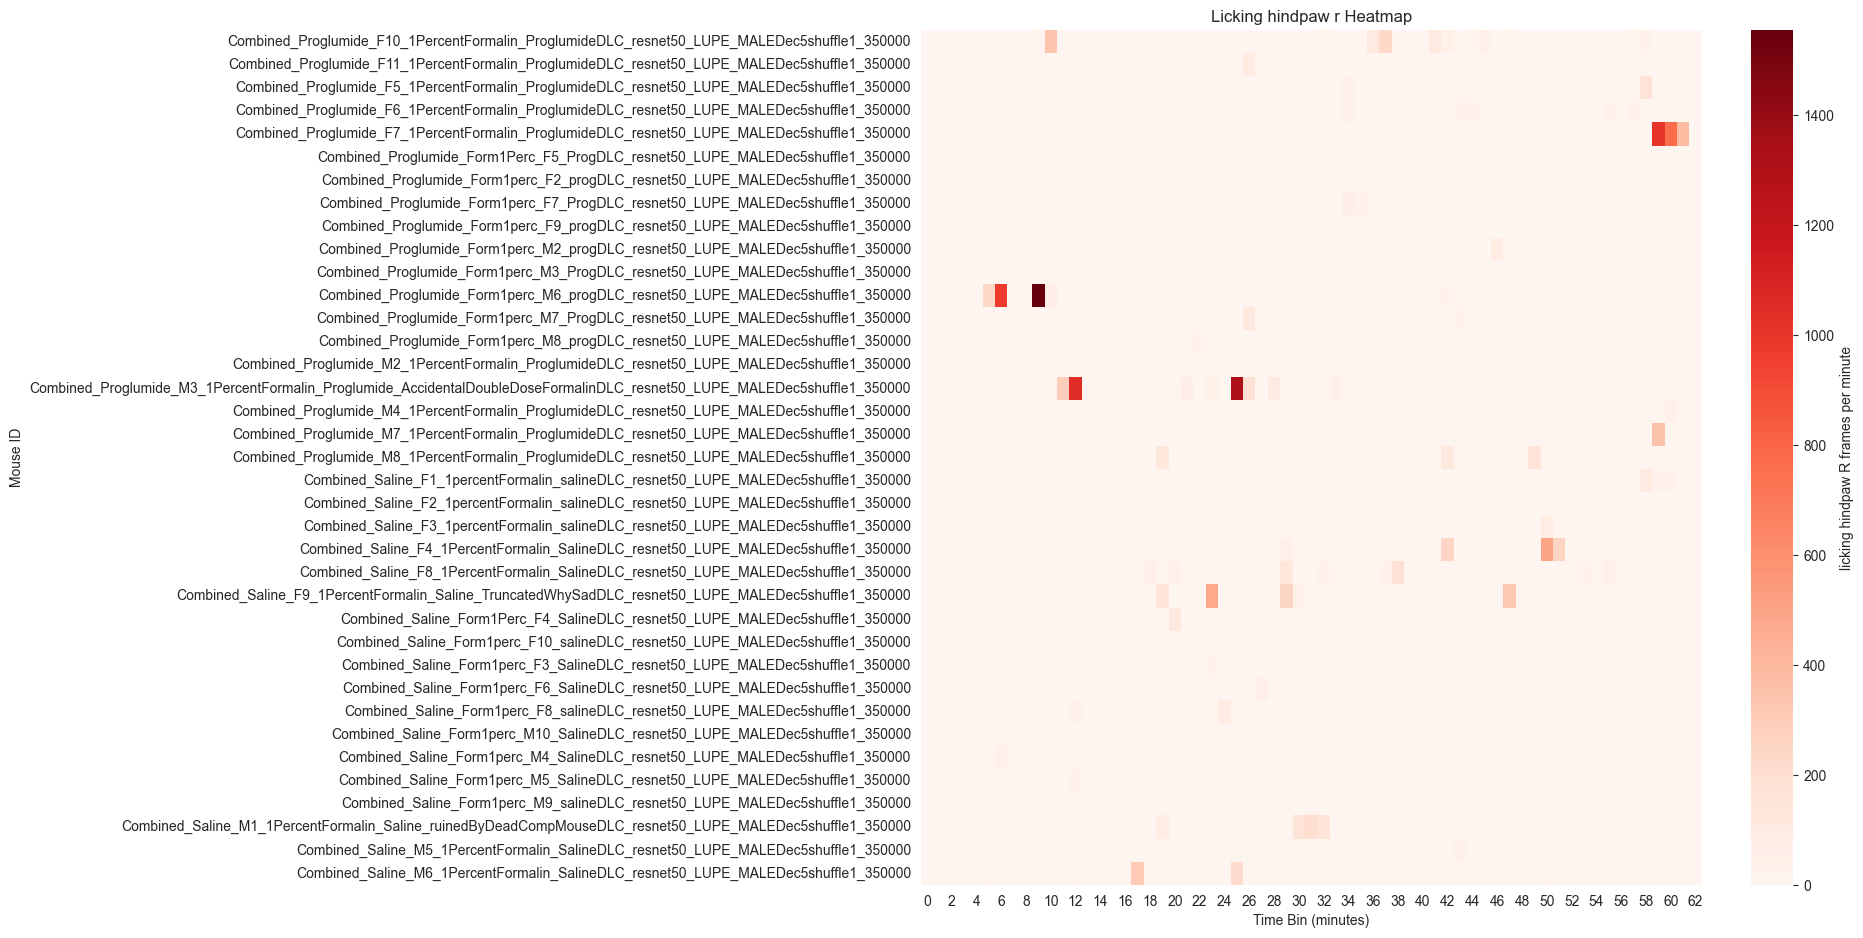

Saved heatmap for 'licking hindpaw R' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/licking_hindpaw_R_heatmap.svg


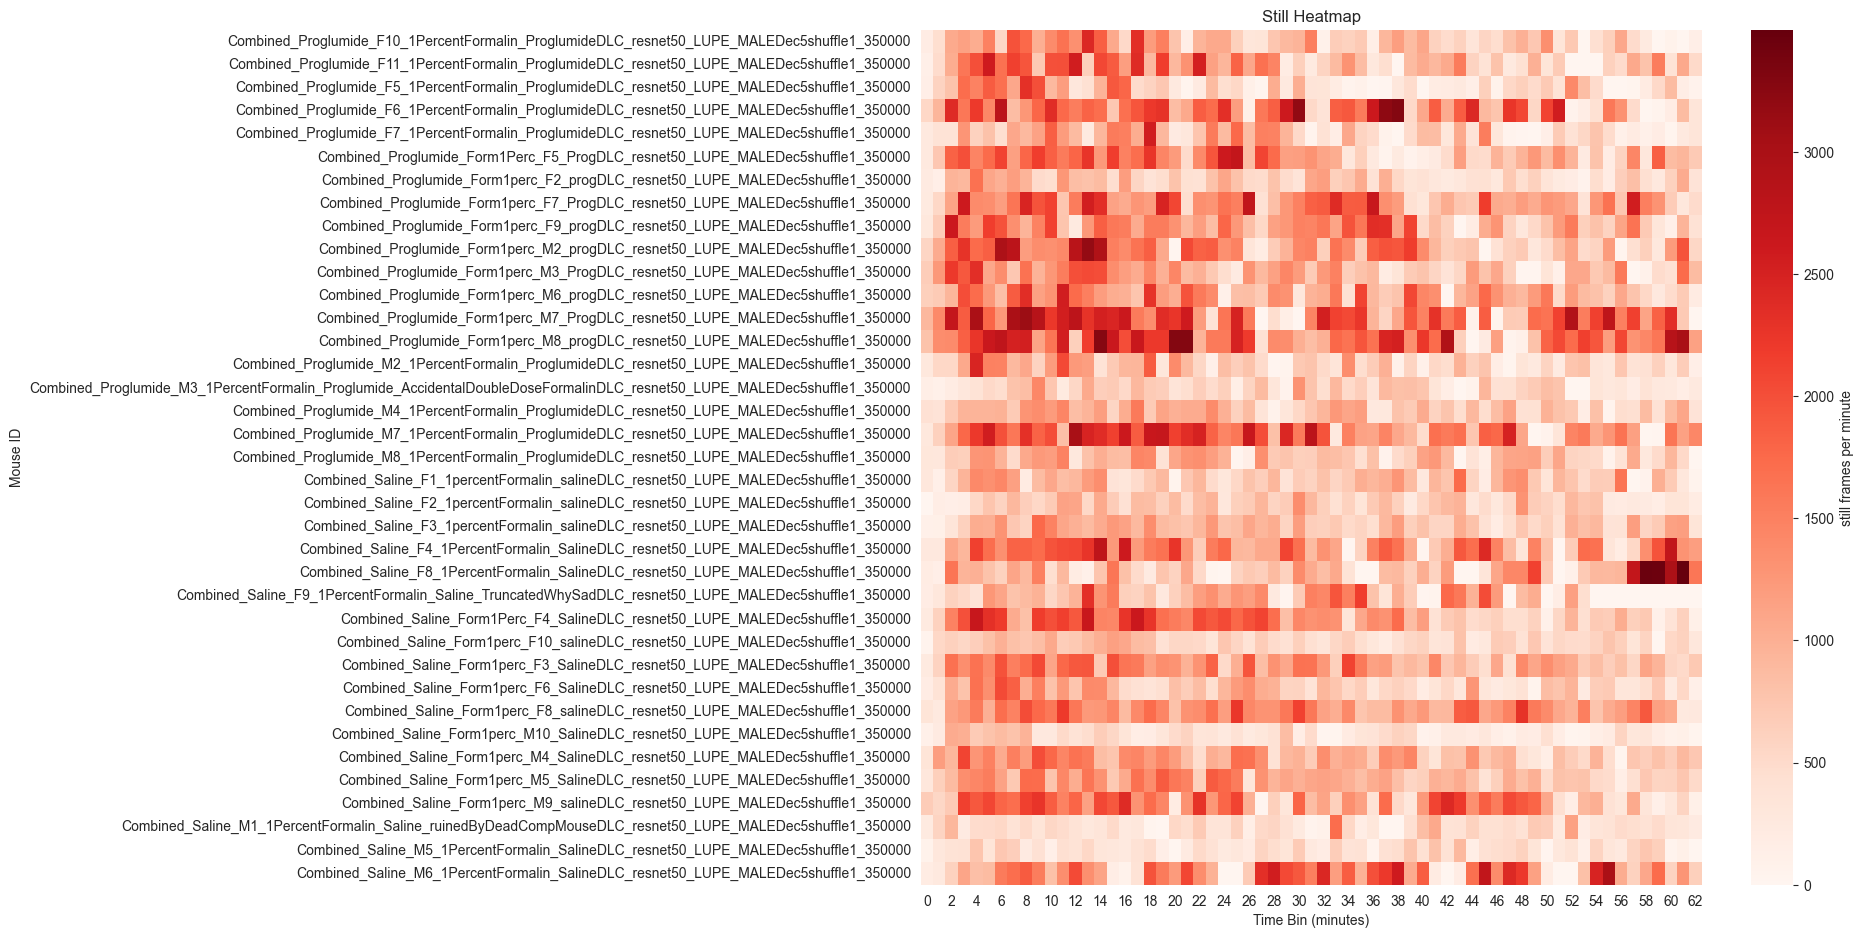

Saved heatmap for 'still' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/still_heatmap.svg


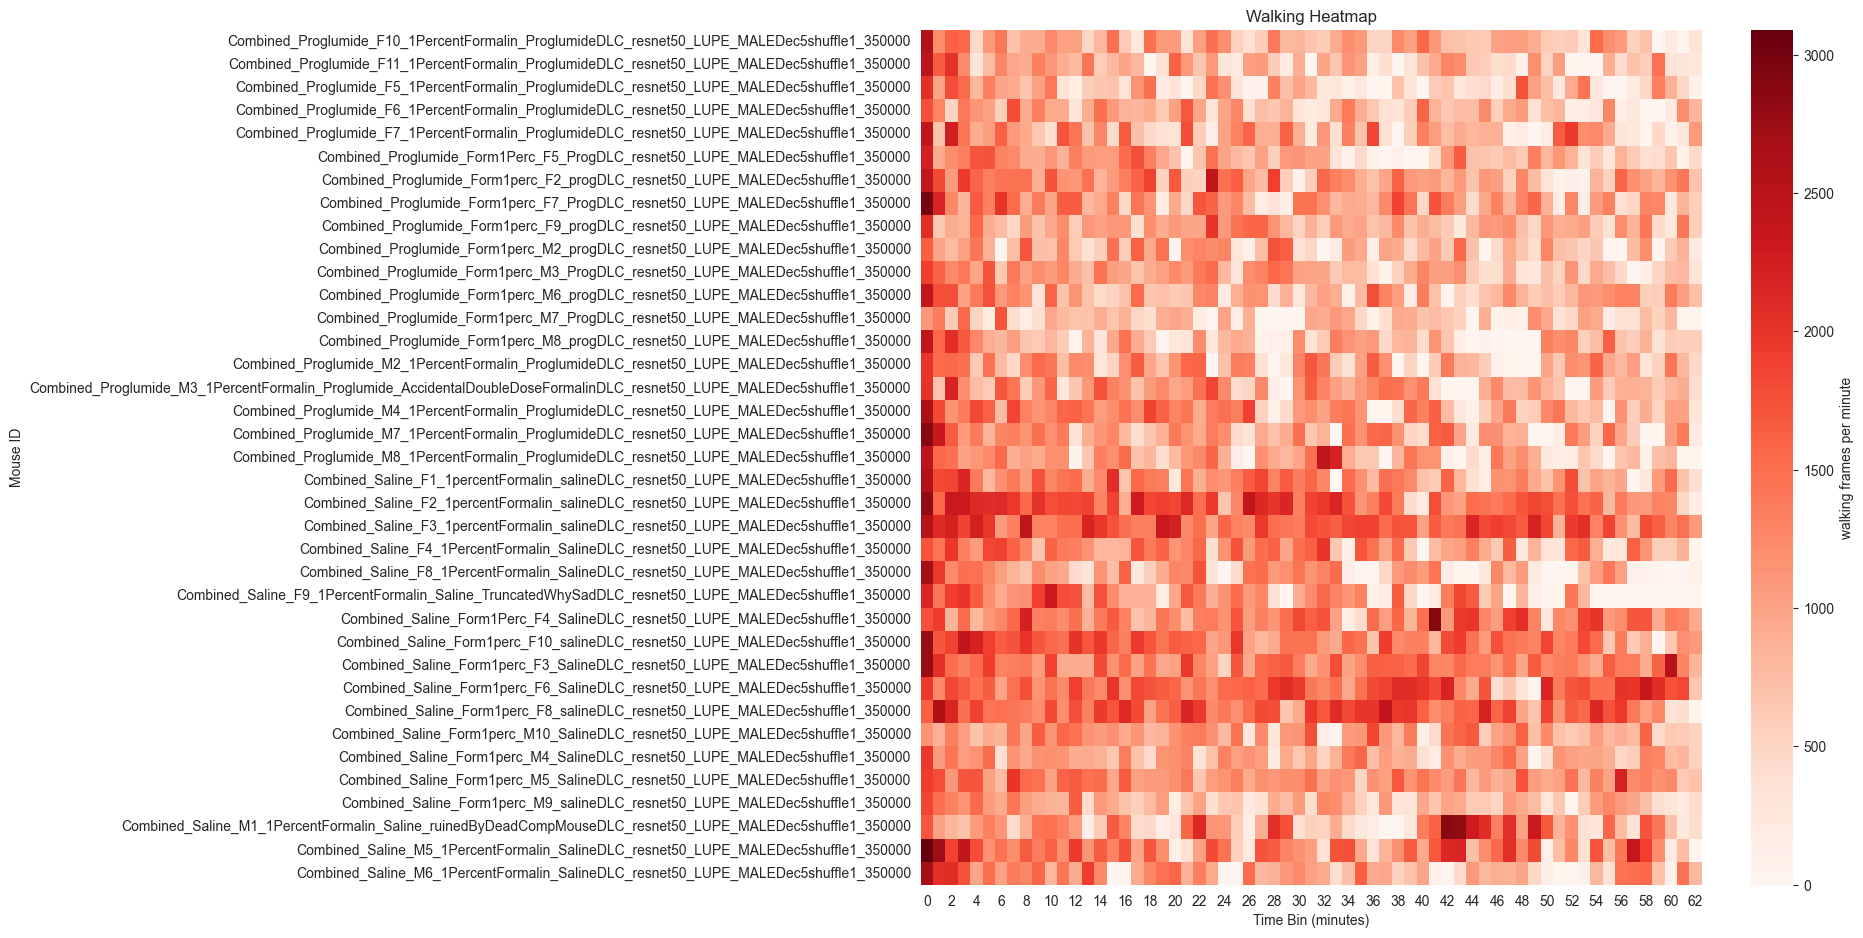

Saved heatmap for 'walking' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/walking_heatmap.svg


In [4]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the parent directory is in sys.path for importing utilities
if os.path.join(os.path.abspath(''), '../') not in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Directory containing the per-frame CSV files
frames_dir = f"../processed_dataset/{project_name}/figures/behaviors_csv_raw-classification/frames"
csv_files = glob.glob(os.path.join(frames_dir, '**', '*.csv'), recursive=True)
print("Found CSV files:", len(csv_files))
for f in csv_files:
    print(os.path.basename(f))

all_data_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        print(f"Processing {os.path.basename(file)}: {df.shape[0]} rows")
        mouse_id = os.path.splitext(os.path.basename(file))[0]
        df['mouse_id'] = mouse_id
        df['behavior'] = df['behavior'].astype(int)
        df['behavior_label'] = df['behavior'].apply(lambda x: behavior_names[x])
        df['time_s'] = df['frame'] / 60.0
        
        if not df.empty:
            all_data_list.append(df)
        else:
            print(f"Warning: {file} is empty. Skipping.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not all_data_list:
    raise ValueError("No dataframes were loaded. Please check that the CSV files in the folder contain valid data.")

all_data = pd.concat(all_data_list, ignore_index=True)
print("Combined all_data shape:", all_data.shape)

all_mice = sorted(all_data['mouse_id'].unique())

max_time_min_bin = int(all_data['time_s'].max() // 60)
print("Number of unique mice:", len(all_mice))
print("Maximum minute bin:", max_time_min_bin)

analysis_dir = f"../processed_dataset/{project_name}/figures/behavior_individual-mouse-screening"
os.makedirs(analysis_dir, exist_ok=True)

for behavior in behavior_names:
    df_behavior = all_data[all_data['behavior_label'] == behavior].copy()
    df_behavior['time_min_bin'] = (df_behavior['time_s'] // 60).astype(int)
    
    csv_data = df_behavior.groupby(['mouse_id', 'time_min_bin']).size().unstack(fill_value=0)
    csv_data = csv_data.reindex(
        index=all_mice,
        columns=range(max_time_min_bin + 1),
        fill_value=0
    )
    
    csv_filename = os.path.join(analysis_dir, f"{behavior.replace(' ', '_')}_data.csv")
    csv_data.to_csv(csv_filename)
    print(f"Saved CSV data for '{behavior}' to {csv_filename}")

fixed_vmax = None

# Recursively collect all per-behavior CSVs, including subdirectories for group/condition
heatmap_csv_files = glob.glob(os.path.join(analysis_dir, "**", "*_data.csv"), recursive=True)
for csv_file in heatmap_csv_files:
    base_name = os.path.basename(csv_file)
    behavior_name = base_name.replace("_data.csv", "").replace("_", " ")

    # Load data
    data = pd.read_csv(csv_file, index_col=0)
    # Dynamically size the figure to accommodate all rows and columns
    num_rows, num_cols = data.shape
    fig_width = max(12, num_cols * 0.2)   # width scales with number of time bins
    fig_height = max(6, num_rows * 0.3)   # height scales with number of mice
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        data,
        cmap='Reds',
        vmin=0,
        vmax=fixed_vmax,
        cbar_kws={'label': f'{behavior_name} frames per minute'}
    )
    plt.xlabel("Time Bin (minutes)")
    plt.ylabel("Mouse ID")
    plt.title(f"{behavior_name.capitalize()} Heatmap")

    svg_filename = os.path.join(analysis_dir, f"{behavior_name.replace(' ', '_')}_heatmap.svg")
    plt.savefig(svg_filename, format='svg', bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Saved heatmap for '{behavior_name}' as {svg_filename}")

### Alt Code: Create Heatmap per Mouse, Screening Behavior Instances per Bin (ACROSS EACH CONDITION per Group)


Processing Group: Combined, Condition: Saline
Found 18 CSV files in ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_csv_raw-classification/frames/Combined/Saline
Processing Combined_Saline_F4_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Saline_Form1perc_F3_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Saline_M1_1PercentFormalin_Saline_ruinedByDeadCompMouseDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Saline_Form1Perc_F4_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 225000 rows
Processing Combined_Saline_Form1perc_F8_salineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Saline_M5_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 225000 rows
Processing Combined_Saline_M6_1PercentFormalin_SalineDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 225000 rows
Processing

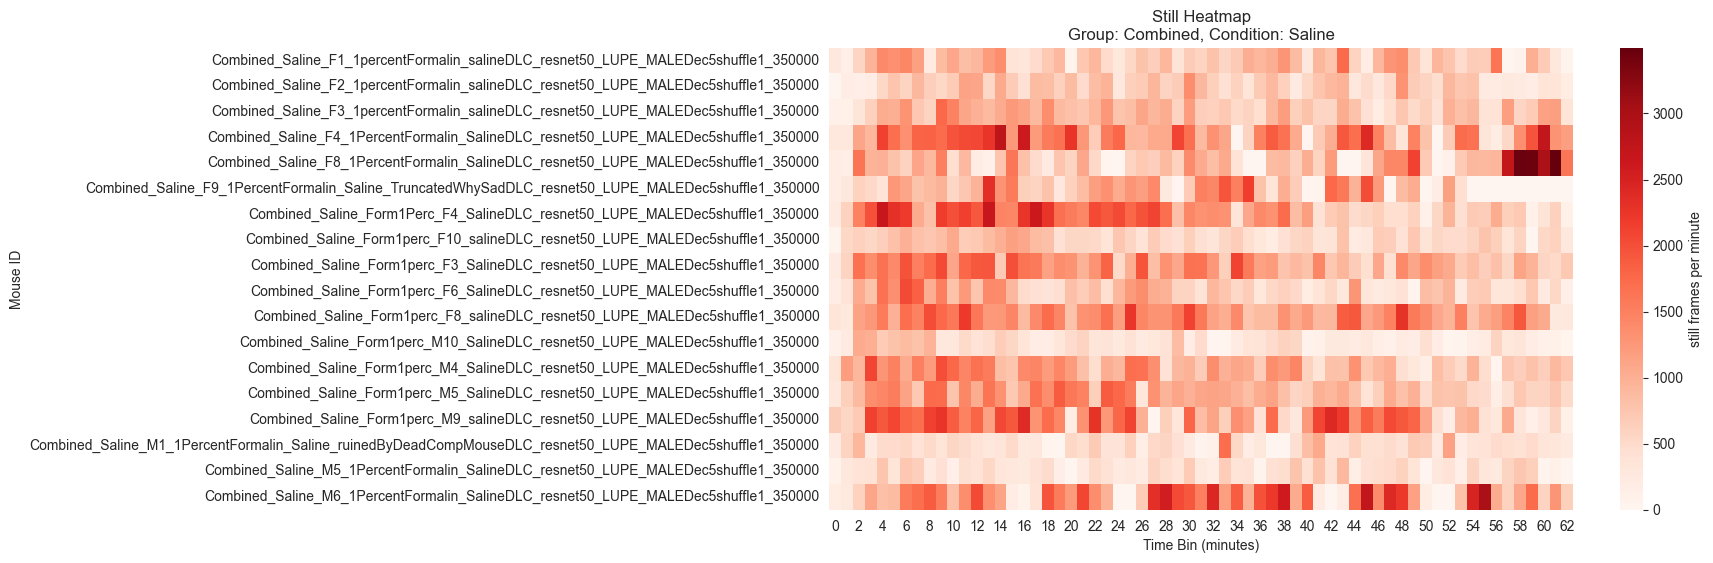

Saved heatmap for 'still' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/still_heatmap.svg
Saved CSV data for 'walking' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/walking_data.csv


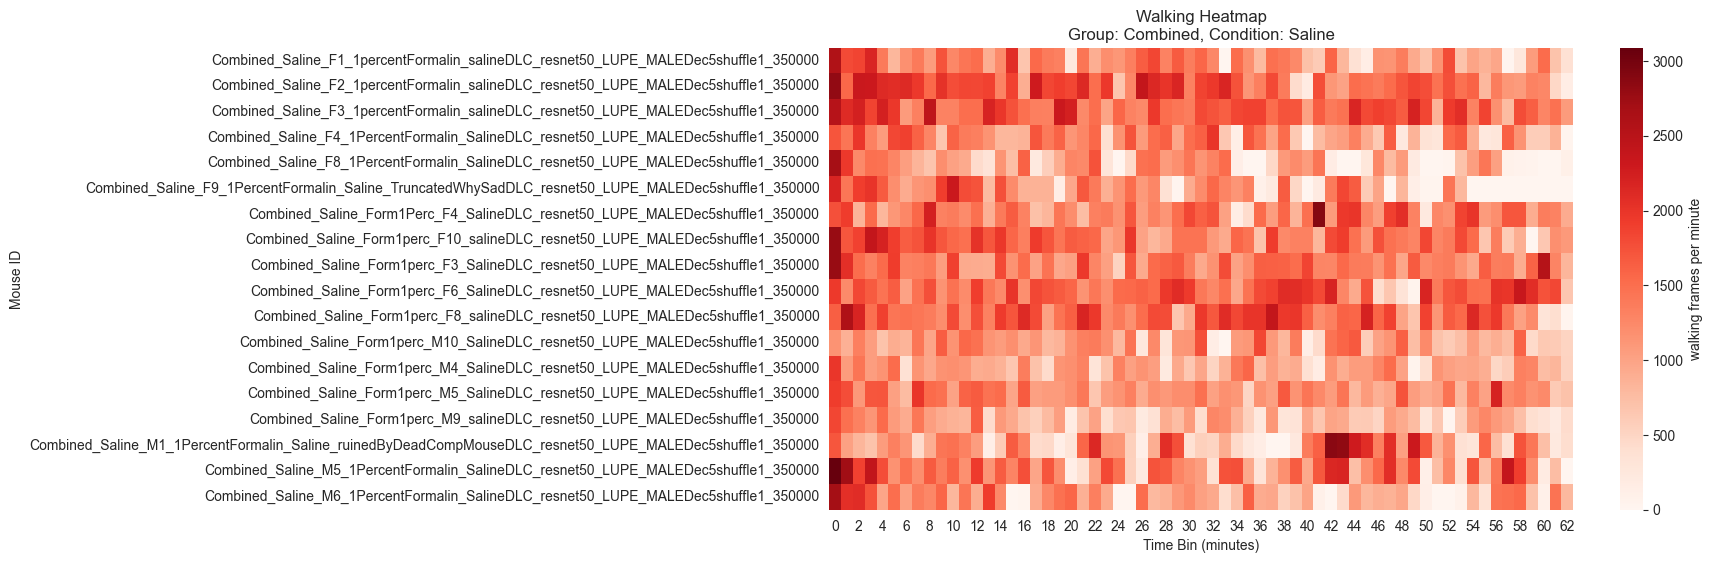

Saved heatmap for 'walking' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/walking_heatmap.svg
Saved CSV data for 'rearing' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/rearing_data.csv


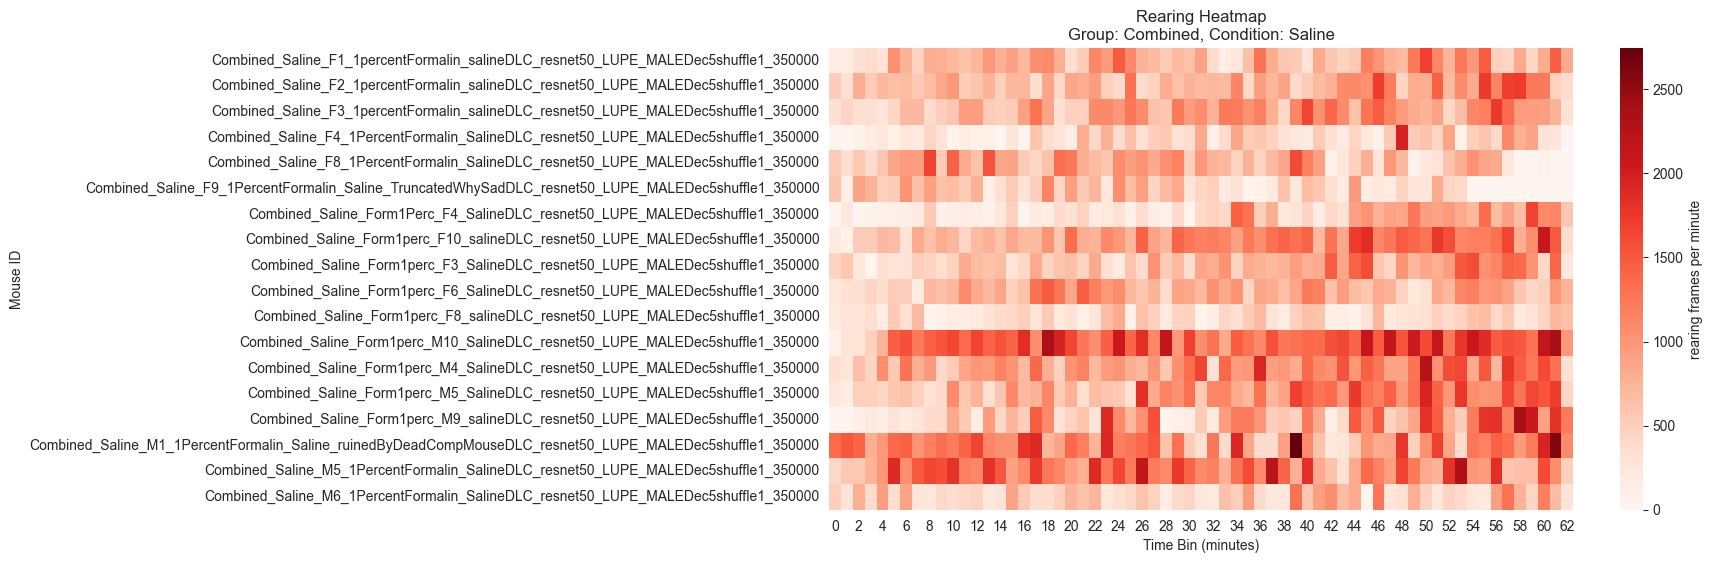

Saved heatmap for 'rearing' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/rearing_heatmap.svg
Saved CSV data for 'grooming' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/grooming_data.csv


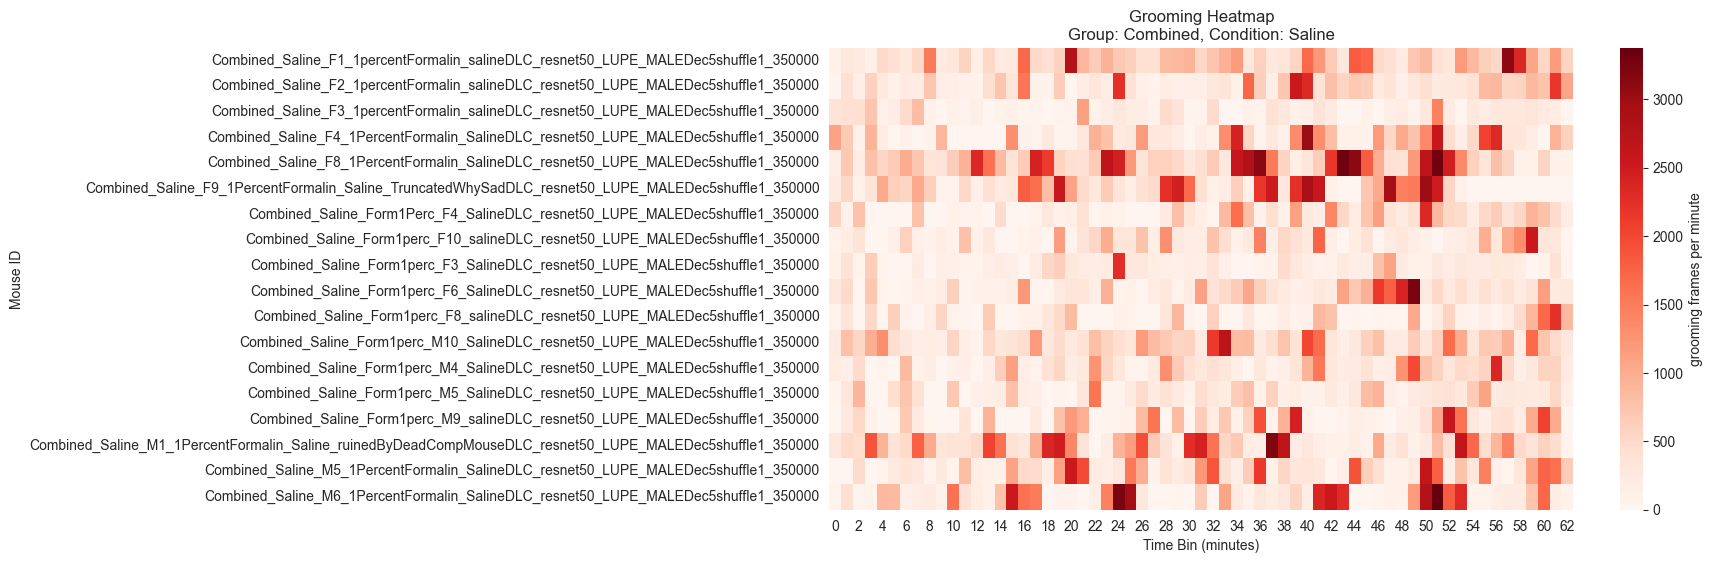

Saved heatmap for 'grooming' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/grooming_heatmap.svg
Saved CSV data for 'licking hindpaw L' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/licking_hindpaw_L_data.csv


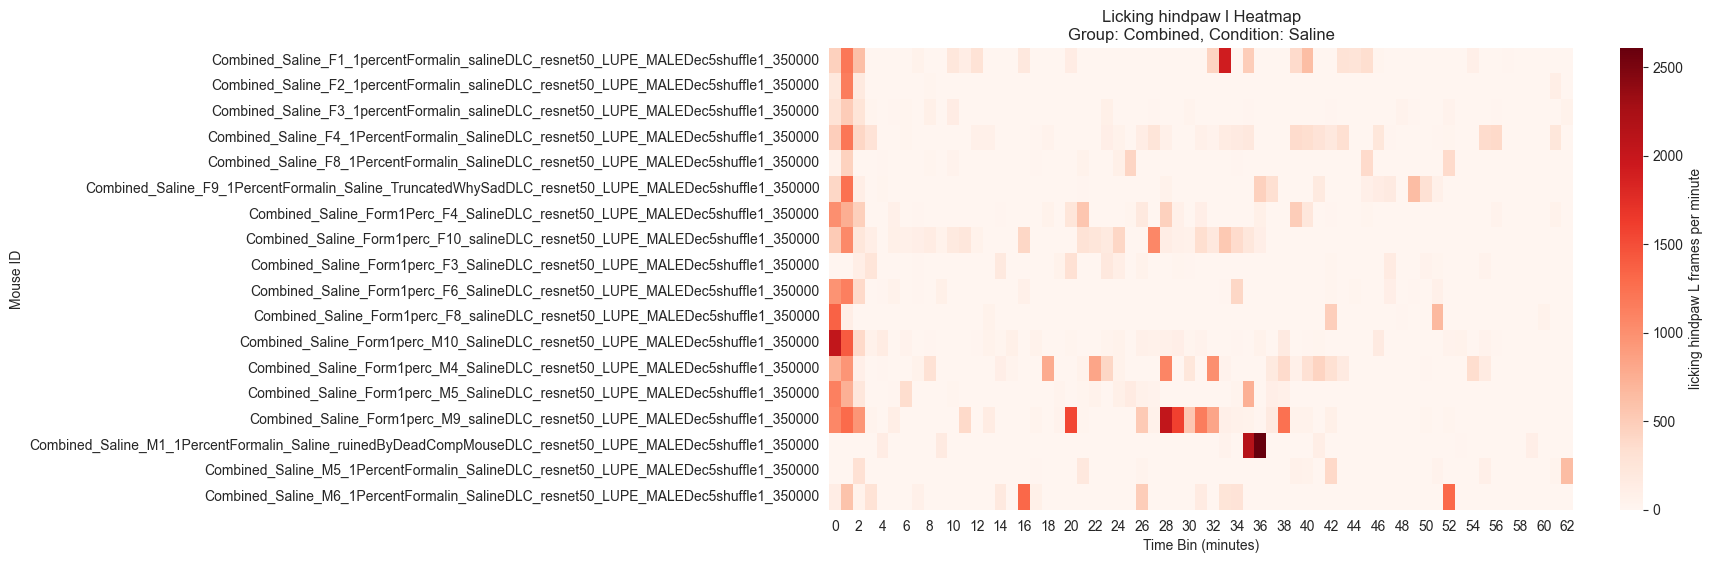

Saved heatmap for 'licking hindpaw L' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/licking_hindpaw_L_heatmap.svg
Saved CSV data for 'licking hindpaw R' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/licking_hindpaw_R_data.csv


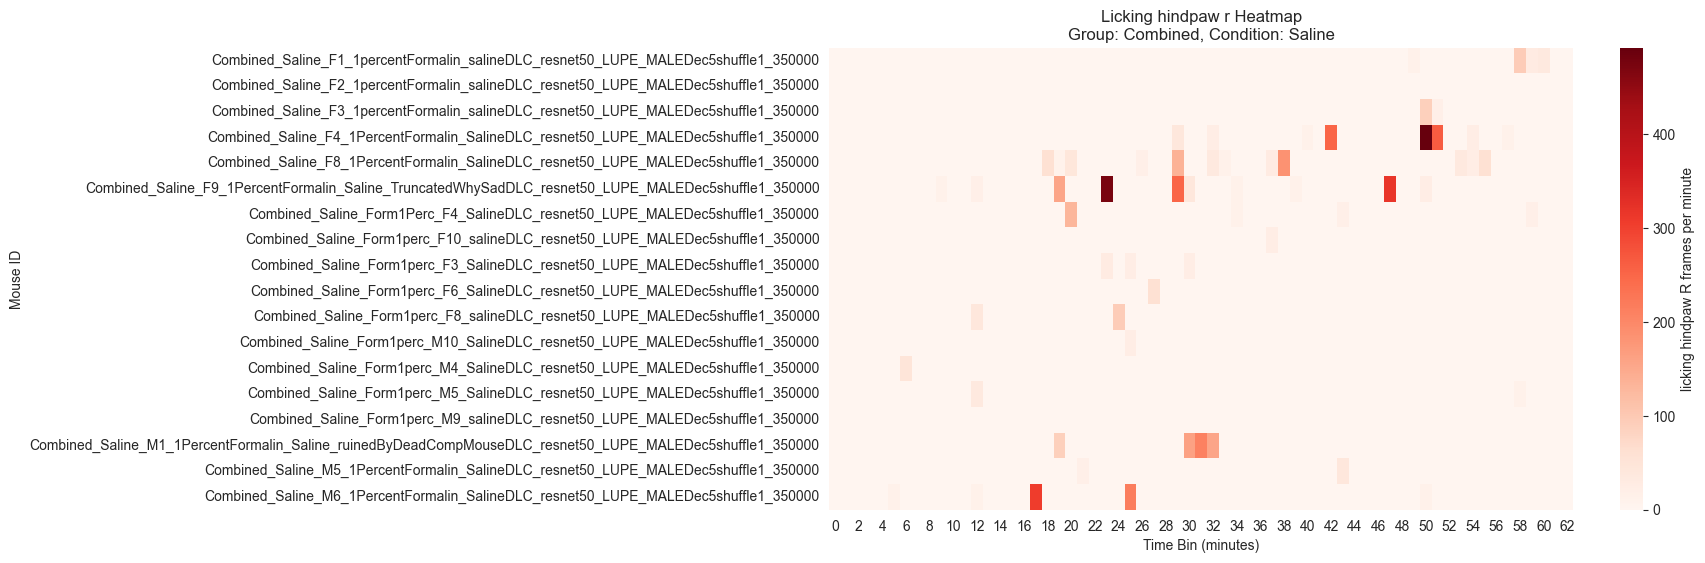

Saved heatmap for 'licking hindpaw R' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Saline/licking_hindpaw_R_heatmap.svg

Processing Group: Combined, Condition: Proglumide
Found 19 CSV files in ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_csv_raw-classification/frames/Combined/Proglumide
Processing Combined_Proglumide_Form1perc_M6_progDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Proglumide_M8_1PercentFormalin_ProglumideDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Proglumide_Form1perc_M7_ProgDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing Combined_Proglumide_F6_1PercentFormalin_ProglumideDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 225001 rows
Processing Combined_Proglumide_M2_1PercentFormalin_ProglumideDLC_resnet50_LUPE_MALEDec5shuffle1_350000.csv: 224999 rows
Processing

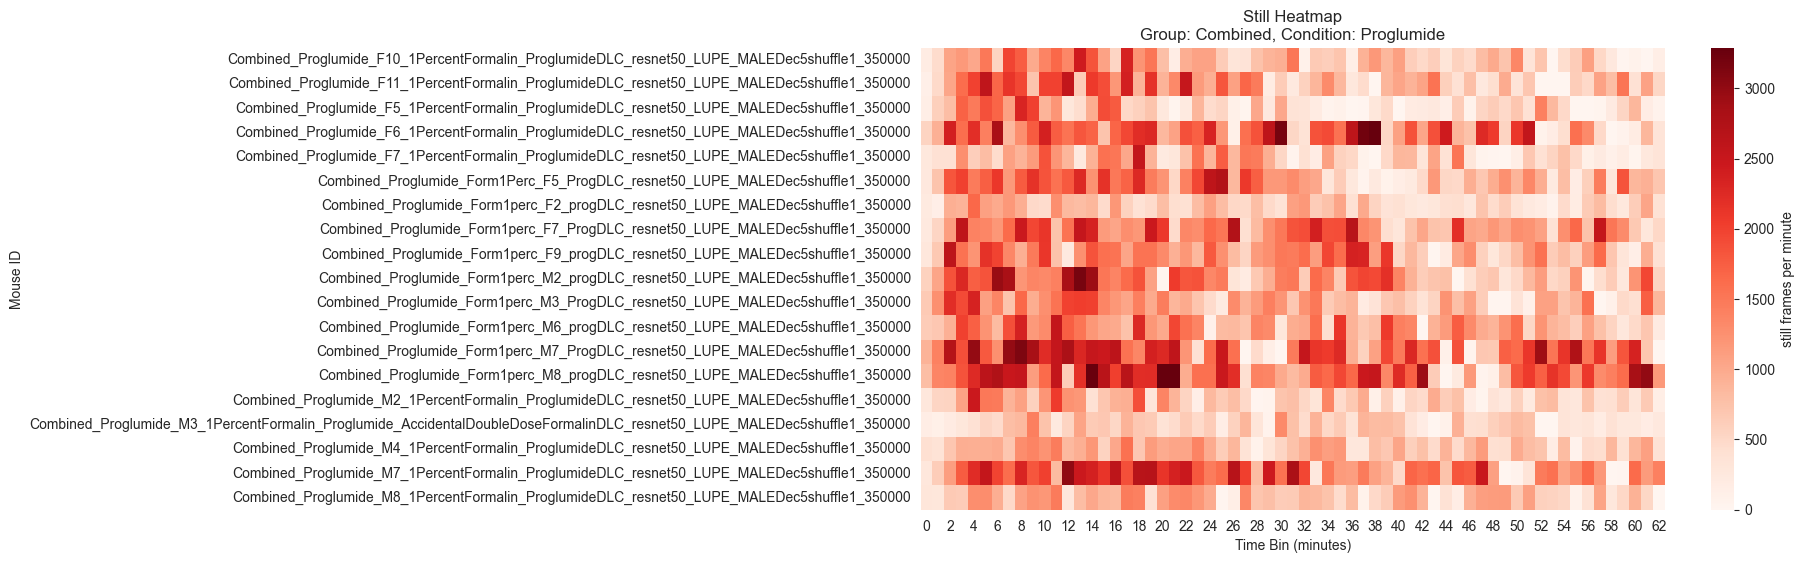

Saved heatmap for 'still' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/still_heatmap.svg
Saved CSV data for 'walking' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/walking_data.csv


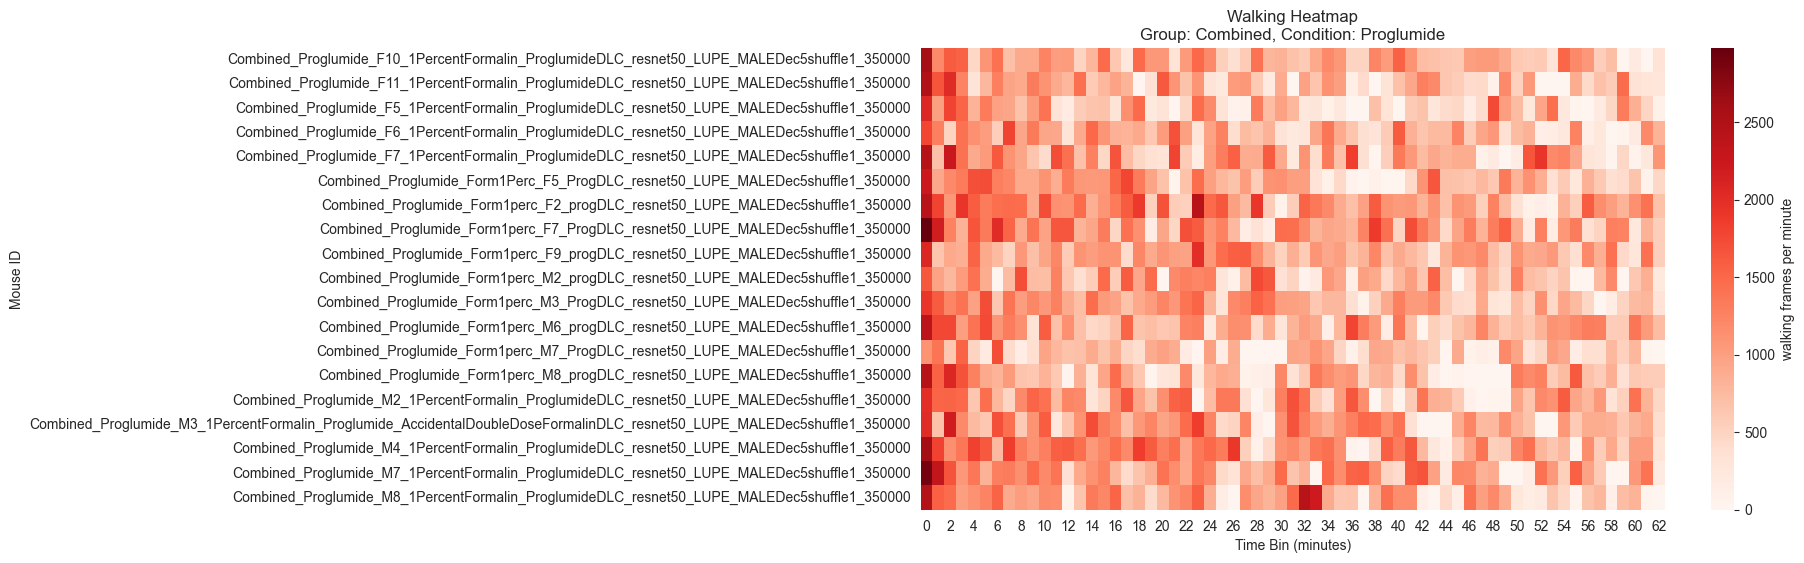

Saved heatmap for 'walking' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/walking_heatmap.svg
Saved CSV data for 'rearing' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/rearing_data.csv


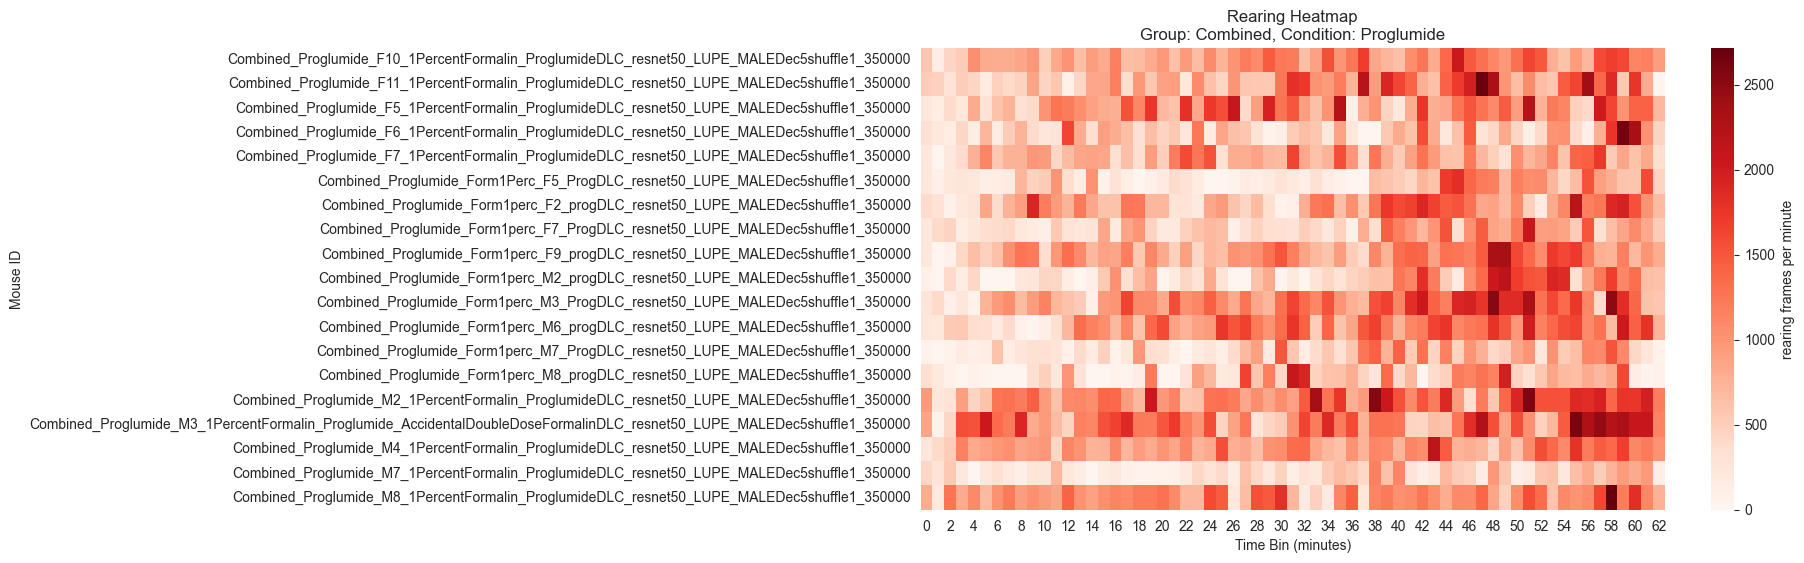

Saved heatmap for 'rearing' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/rearing_heatmap.svg
Saved CSV data for 'grooming' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/grooming_data.csv


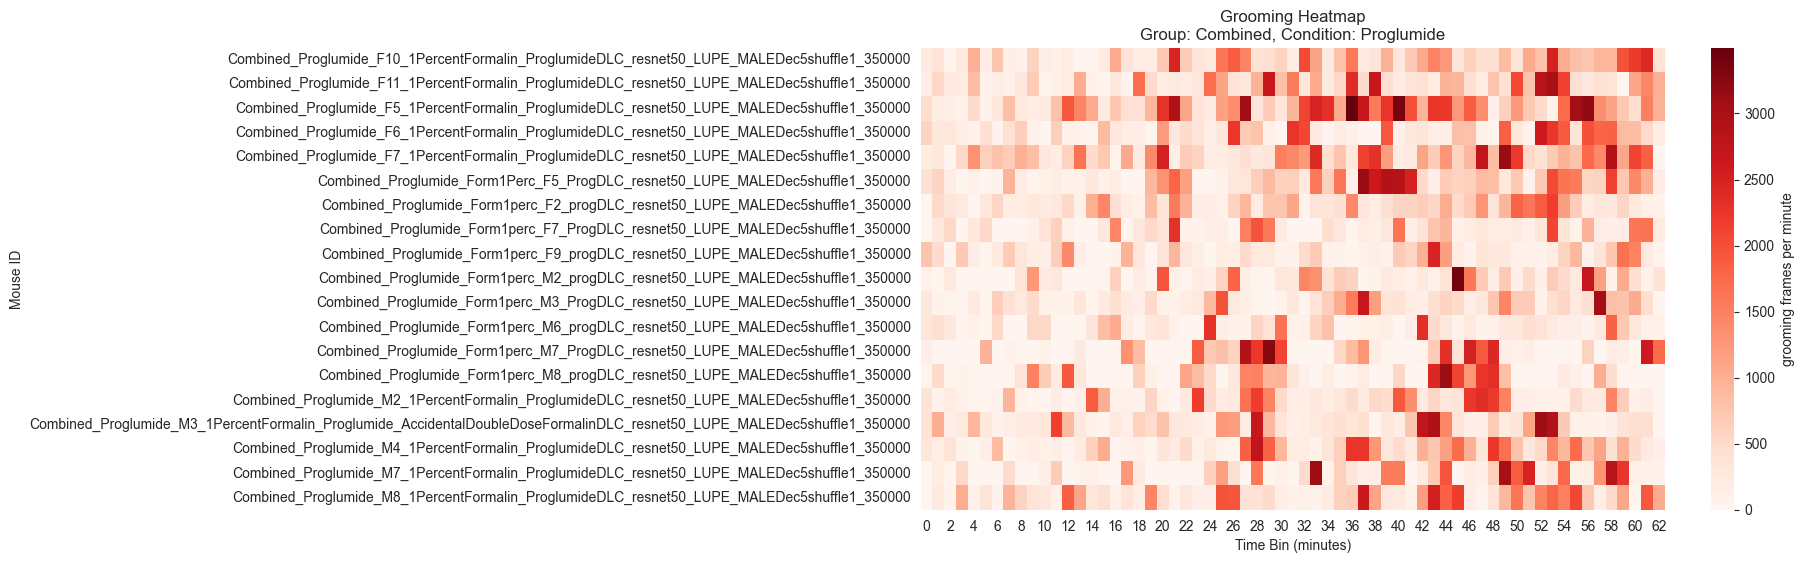

Saved heatmap for 'grooming' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/grooming_heatmap.svg
Saved CSV data for 'licking hindpaw L' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/licking_hindpaw_L_data.csv


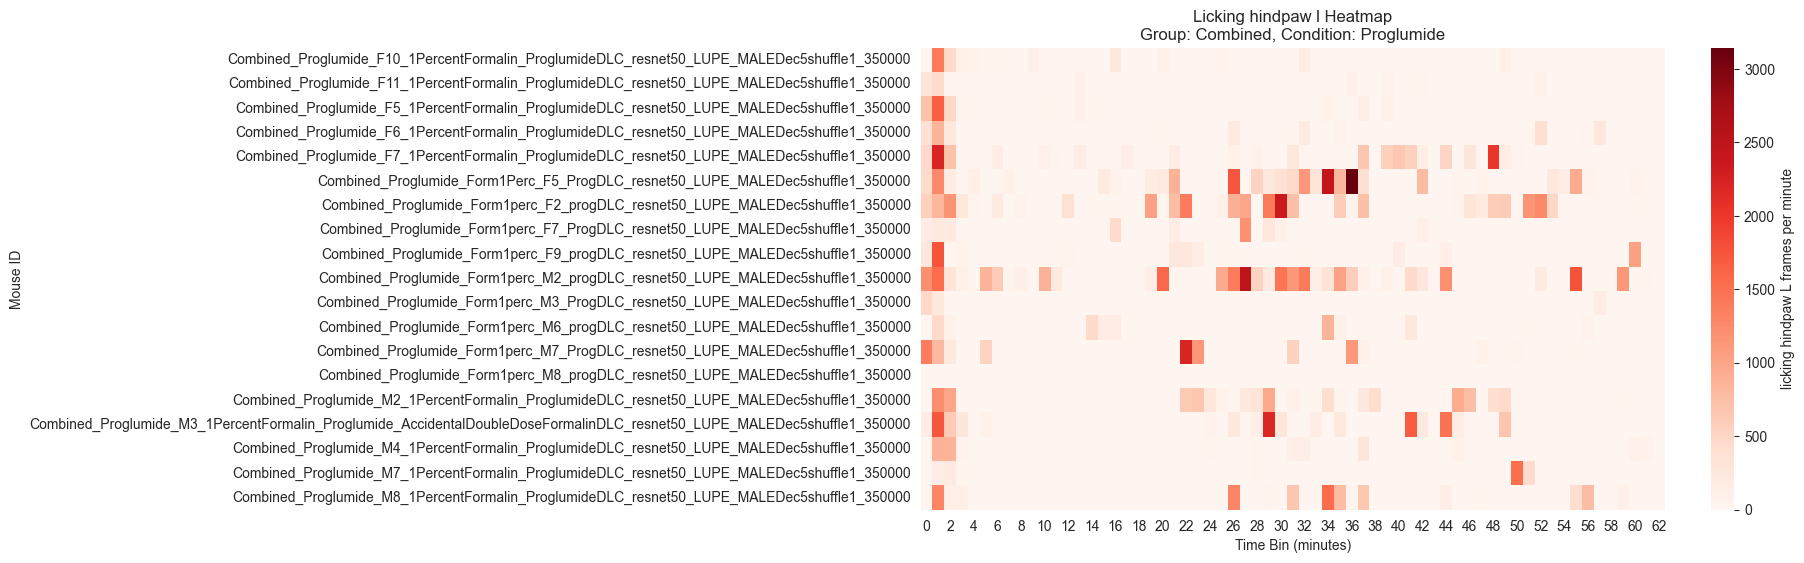

Saved heatmap for 'licking hindpaw L' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/licking_hindpaw_L_heatmap.svg
Saved CSV data for 'licking hindpaw R' to ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/licking_hindpaw_R_data.csv


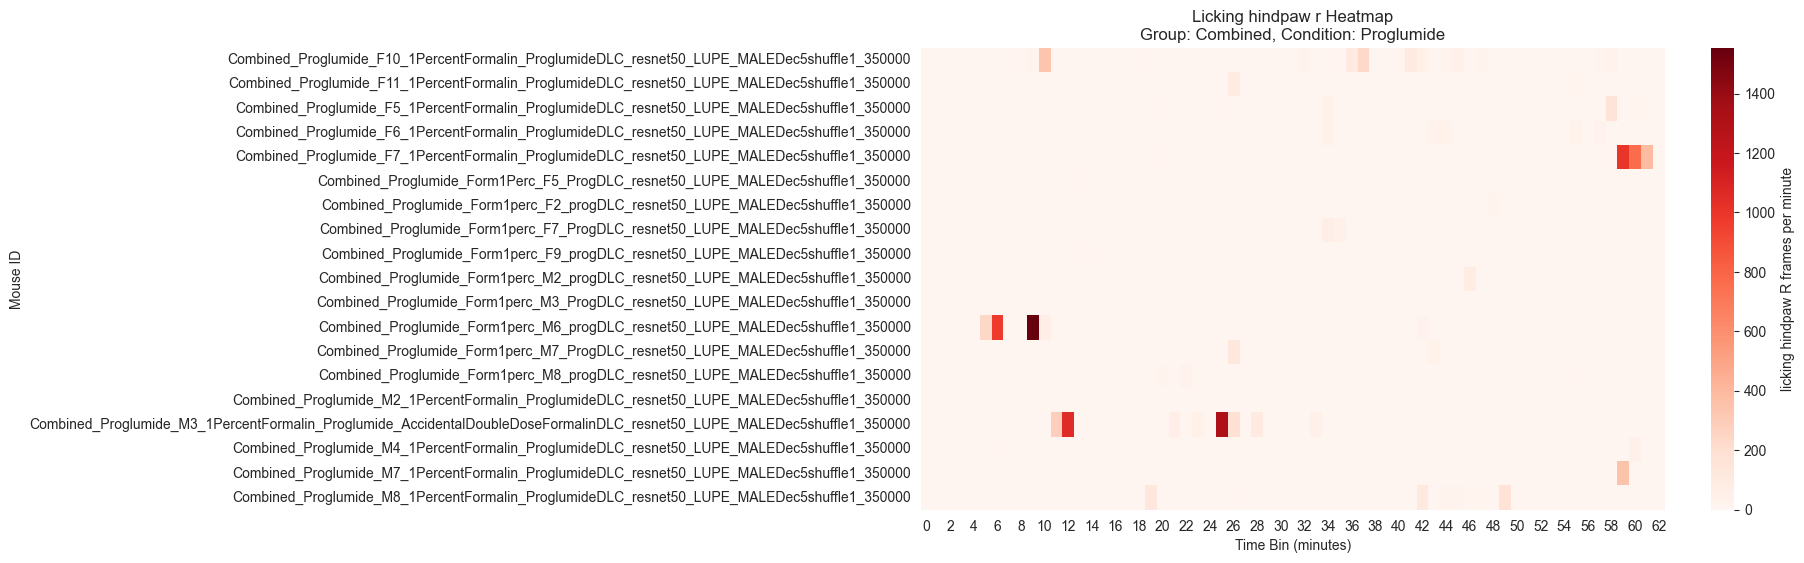

Saved heatmap for 'licking hindpaw R' as ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behavior_individual-mouse-screening/Combined/Proglumide/licking_hindpaw_R_heatmap.svg


In [5]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the parent directory is in sys.path for importing utilities
if os.path.join(os.path.abspath(''), '../') not in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

base_frames_dir = f"../processed_dataset/{project_name}/figures/behaviors_csv_raw-classification/frames"
base_analysis_dir = f"../processed_dataset/{project_name}/figures/behavior_individual-mouse-screening"

for group in selected_groups:
    for condition in selected_conditions:
        print(f"\nProcessing Group: {group}, Condition: {condition}")
        
        current_frames_dir = os.path.join(base_frames_dir, group, condition)
        csv_files = glob.glob(os.path.join(current_frames_dir, '**', '*.csv'), recursive=True)
        print(f"Found {len(csv_files)} CSV files in {current_frames_dir}")
        
        if len(csv_files) == 0:
            print(f"No CSV files found for Group: {group}, Condition: {condition}. Skipping...")
            continue
        
        all_data_list = []
        for file in csv_files:
            try:
                df = pd.read_csv(file)
                print(f"Processing {os.path.basename(file)}: {df.shape[0]} rows")
                mouse_id = os.path.splitext(os.path.basename(file))[0]
                df['mouse_id'] = mouse_id
                df['behavior'] = df['behavior'].astype(int)
                df['behavior_label'] = df['behavior'].apply(lambda x: behavior_names[x])
                df['time_s'] = df['frame'] / 60.0
                if not df.empty:
                    all_data_list.append(df)
                else:
                    print(f"Warning: {file} is empty. Skipping.")
            except Exception as e:
                print(f"Error reading {file}: {e}")
        
        if not all_data_list:
            print(f"No valid data for Group: {group}, Condition: {condition}. Skipping...")
            continue
        
        all_data = pd.concat(all_data_list, ignore_index=True)
        print("Combined data shape:", all_data.shape)
        
        all_mice = sorted(all_data['mouse_id'].unique())
        max_time_min_bin = int(all_data['time_s'].max() // 60)
        print(f"Unique mice: {len(all_mice)}; Maximum minute bin: {max_time_min_bin}")
        
        current_analysis_dir = os.path.join(base_analysis_dir, group, condition)
        os.makedirs(current_analysis_dir, exist_ok=True)
        
        for behavior in behavior_names:
            df_behavior = all_data[all_data['behavior_label'] == behavior].copy()
            df_behavior['time_min_bin'] = (df_behavior['time_s'] // 60).astype(int)
            
            csv_data = df_behavior.groupby(['mouse_id', 'time_min_bin']).size().unstack(fill_value=0)
            csv_data = csv_data.reindex(
                index=all_mice,
                columns=range(max_time_min_bin + 1),
                fill_value=0
            )
            
            csv_filename = os.path.join(current_analysis_dir, f"{behavior.replace(' ', '_')}_data.csv")
            csv_data.to_csv(csv_filename)
            print(f"Saved CSV data for '{behavior}' to {csv_filename}")
            
            fixed_vmax = None
            
            plt.figure(figsize=(12, 6))
            sns.heatmap(
                csv_data,
                cmap='Reds',
                vmin=0,
                vmax=fixed_vmax,
                cbar_kws={'label': f'{behavior} frames per minute'}
            )
            plt.xlabel("Time Bin (minutes)")
            plt.ylabel("Mouse ID")
            plt.title(f"{behavior.capitalize()} Heatmap\nGroup: {group}, Condition: {condition}")
            
            svg_filename = os.path.join(current_analysis_dir, f"{behavior.replace(' ', '_')}_heatmap.svg")
            plt.savefig(svg_filename, format='svg', bbox_inches='tight')
            plt.show()
            plt.close()
            
            print(f"Saved heatmap for '{behavior}' as {svg_filename}")

# COMPLETE